In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
import matplotlib.pyplot as plt
import warnings
import pickle
import seaborn as sns

import os
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
%matplotlib inline

load the cleaned data from previous sections and build the dataset with new features

In [2]:
# read in the json files
portfolio = pd.read_pickle('portfolio.pkl')
profile = pd.read_pickle('profile.pkl')
transaction_month = pd.read_pickle('transaction_month.pkl')
offer_spending = pd.read_pickle('offer_spending.pkl')

### Portfolio

In [3]:
portfolio

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,7,1,1,1,0
1,10,10,5,bogo,4,1,1,1,1
2,0,0,4,informational,3,1,1,0,1
3,5,5,7,bogo,6,1,1,0,1
4,5,20,10,discount,0,1,0,0,1
5,3,7,7,discount,1,1,1,1,1
6,2,10,10,discount,9,1,1,1,1
7,0,0,3,informational,5,1,1,1,0
8,5,5,5,bogo,8,1,1,1,1
9,2,10,7,discount,2,1,1,0,1


We will use the features "email", "mobile", "social", "web"

### Profile

In [4]:
profile

,gender,age,income,per_id,member_year,member_month,member_day
1,F,55,112000.0,346,2017,7,15
3,F,75,100000.0,6962,2017,5,9
5,M,68,70000.0,13107,2018,4,26
8,M,65,53000.0,3246,2018,2,9
12,M,58,51000.0,2669,2017,11,11
...,...,...,...,...,...,...,...
16995,F,45,54000.0,6327,2018,6,4
16996,M,61,72000.0,2524,2018,7,13
16997,M,49,73000.0,93,2017,1,26
16998,F,83,50000.0,9208,2016,3,7


In [5]:
# add one hot encoding
data = pd.concat([profile, pd.get_dummies(profile.gender), 
                  pd.get_dummies(profile.member_year), 
                  pd.get_dummies(profile.member_month)], axis=1)
data.rename(columns={2013:'2013', 2014:'2014', 2015:'2015', 2016:'2016', 2017:'2017', 2018:'2018',
                     1:'month_1', 2:'month_2', 3:'month_3', 4:'month_4', 5:'month_5', 6:'month_6', 
                     7:'month_7', 8:'month_8', 9:'month_9', 10:'month_10', 11:'month_11', 12:'month_12'}, inplace=True)
data.head()

,gender,age,income,per_id,member_year,member_month,member_day,F,M,O,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
1,F,55,112000.0,346,2017,7,15,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,F,75,100000.0,6962,2017,5,9,1,0,0,...,0,0,1,0,0,0,0,0,0,0
5,M,68,70000.0,13107,2018,4,26,0,1,0,...,0,1,0,0,0,0,0,0,0,0
8,M,65,53000.0,3246,2018,2,9,0,1,0,...,0,0,0,0,0,0,0,0,0,0
12,M,58,51000.0,2669,2017,11,11,0,1,0,...,0,0,0,0,0,0,0,0,1,0


### transaction_month

In [6]:
transaction_month

,per_id,month_num,amt_spent,num_transactions
0,0,7,22.16,1
1,0,13,8.57,1
2,0,17,14.11,1
3,0,18,13.56,1
4,0,19,10.27,1
...,...,...,...,...
101765,14824,13,17.55,1
101766,14824,16,20.96,2
101767,14824,19,14.23,1
101768,14824,20,10.12,1


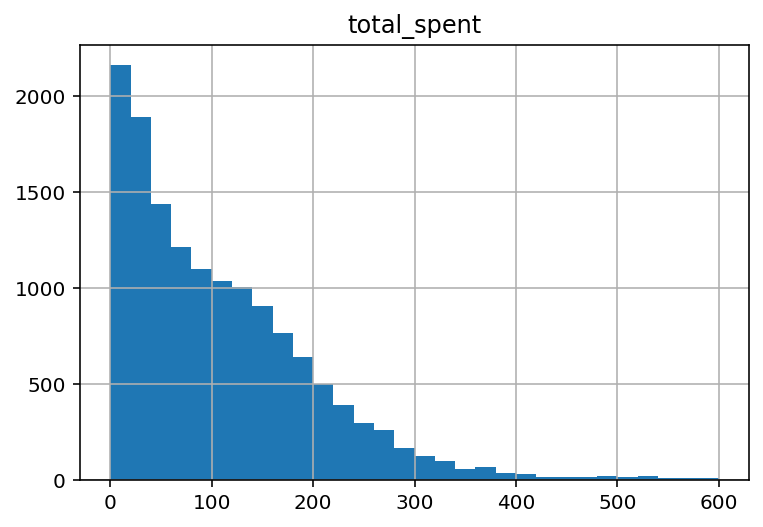

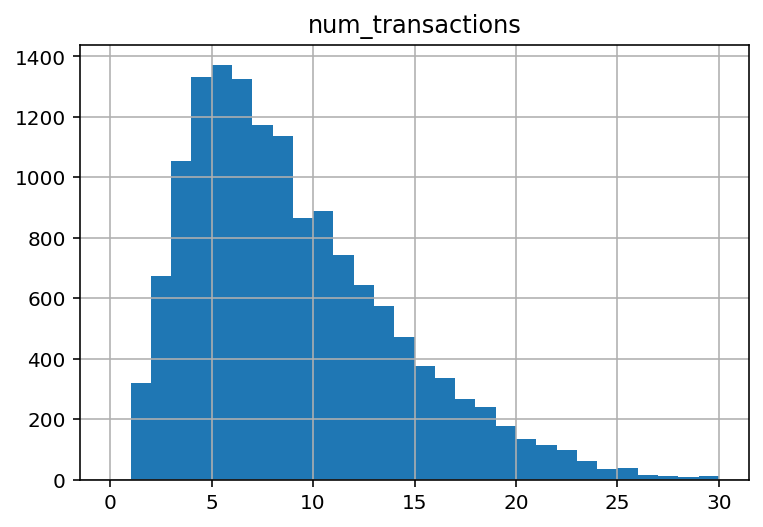

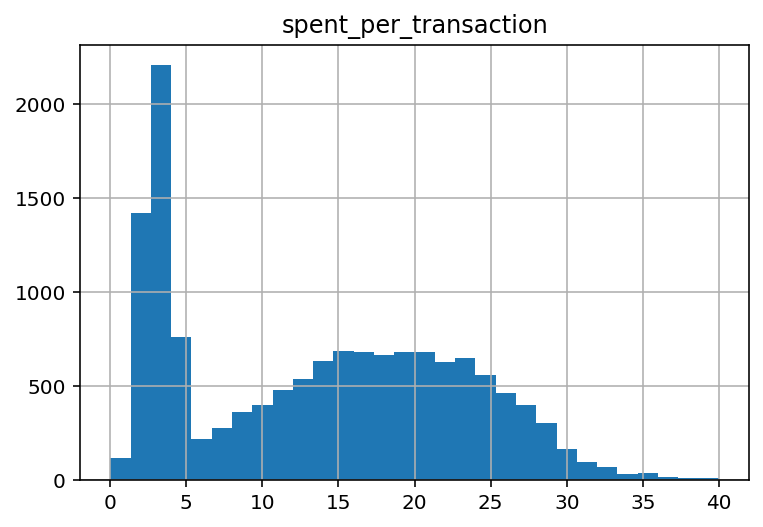

In [7]:
total_spending = transaction_month.groupby('per_id').agg({'amt_spent':'sum', 'num_transactions':'sum'}).reset_index()
total_spending.rename(columns={'amt_spent':'total_spent'}, inplace=True)
total_spending['spent_per_transaction'] = total_spending['total_spent'] / total_spending['num_transactions']

# plot the histogram
total_spending[['total_spent']].hist(bins=30,range=(0, 600))
plt.show()
total_spending[['num_transactions']].hist(bins=30,range=(0, 30))
plt.show()
total_spending[['spent_per_transaction']].hist(bins=30,range=(0, 40))
plt.show()

The spent_per_transaction is an interesting feature. some people spent more than 10 dollers. They might not just purchase coffee for themselves but for their friends or colleages. 

In [8]:
data = pd.merge(data, total_spending, on = ['per_id'], how='left')
data['total_spent'].fillna(0, inplace=True)
data['num_transactions'].fillna(0, inplace=True)
data['spent_per_transaction'].fillna(0, inplace=True)
data

,gender,age,income,per_id,member_year,member_month,member_day,F,M,O,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,total_spent,num_transactions,spent_per_transaction
0,F,55,112000.0,346,2017,7,15,1,0,0,...,0,1,0,0,0,0,0,77.01,3.0,25.670000
1,F,75,100000.0,6962,2017,5,9,1,0,0,...,0,0,0,0,0,0,0,159.27,7.0,22.752857
2,M,68,70000.0,13107,2018,4,26,0,1,0,...,0,0,0,0,0,0,0,57.73,3.0,19.243333
3,M,65,53000.0,3246,2018,2,9,0,1,0,...,0,0,0,0,0,0,0,36.43,3.0,12.143333
4,M,58,51000.0,2669,2017,11,11,0,1,0,...,0,0,0,0,0,1,0,15.62,4.0,3.905000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14820,F,45,54000.0,6327,2018,6,4,1,0,0,...,1,0,0,0,0,0,0,20.03,7.0,2.861429
14821,M,61,72000.0,2524,2018,7,13,0,1,0,...,0,1,0,0,0,0,0,25.97,7.0,3.710000
14822,M,49,73000.0,93,2017,1,26,0,1,0,...,0,0,0,0,0,0,0,39.74,8.0,4.967500
14823,F,83,50000.0,9208,2016,3,7,1,0,0,...,0,0,0,0,0,0,0,189.67,14.0,13.547857


### offer_spending

In [9]:
offer_spending

,person_id,month_num,offer_id,profit,failed_offer,mean,std,above_mean,viewed_and_above_mean
0,4,11,3.0,2.29,1.0,1.743913,2.507999,True,0
1,4,13,9.0,5.94,1.0,1.743913,2.507999,True,0
2,5,11,0.0,4.72,1.0,2.773478,5.165133,True,0
3,8,19,7.0,10.65,0.0,0.422174,1.374855,True,1
4,12,5,9.0,6.86,1.0,2.029130,2.554527,True,0
...,...,...,...,...,...,...,...,...,...
55742,11139,19,0.0,0.00,1.0,3.267826,8.772813,False,0
55743,5964,19,0.0,0.00,1.0,5.146522,7.408420,False,0
55744,14424,19,5.0,0.00,1.0,8.780000,14.580680,False,0
55745,6327,19,1.0,0.00,1.0,0.870870,1.689512,False,0


In [10]:
# merge offer_spending with portfolio
offer_spending = pd.merge(offer_spending, portfolio[['offer_id','mobile','email','web',
                                                     'social','reward','difficulty','duration']], 
         on=['offer_id'], how='left')
data.rename(columns={'per_id':'person_id'}, inplace=True)
data = pd.merge(offer_spending, data, on='person_id', how='inner')

In [11]:
data.columns

Index(['person_id', 'month_num', 'offer_id', 'profit', 'failed_offer', 'mean',
       'std', 'above_mean', 'viewed_and_above_mean', 'mobile', 'email', 'web',
       'social', 'reward', 'difficulty', 'duration', 'gender', 'age', 'income',
       'member_year', 'member_month', 'member_day', 'F', 'M', 'O', '2013',
       '2014', '2015', '2016', '2017', '2018', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'total_spent', 'num_transactions',
       'spent_per_transaction'],
      dtype='object')

### Bin the numerical features

In [12]:
# bin the continous features into ordinal features
# age, income, total_spent, num_transactions, spent_per_transaction
data['age_by_decade'] = pd.cut(data['age'], bins=[10,20,30,40,50,60,70,120],right=False, 
                               labels=['age_10s','age_20s', 'age_30s', 'age_40s', 'age_50s','age_60s', 
                                       'age_70s+'])
data['income_by_range'] = pd.cut(data['income'], bins=[3e4,5e4,7e4, 9e4,15e4], right=False,
                                  labels=['income_30k-50k','income_50k-70k','income_70k-90k',
                                          'income_90k+'])
data['total_spent_by_range'] = pd.cut(data['total_spent'], bins=[0,20,100,200,300,400,2000], right=False,
                                     labels=['spent_0-20','spent_20-100', 'spent_100-200','spent_200-300',
                                             'spent_300-400','spent_400+'])
data['num_transactions_frequency'] = pd.cut(data['num_transactions'], bins=[0,5,10,15,20,100],
                                            labels=['freq_0-5','freq_5-10','freq_10-15','freq_15-20','freq_20+'])


data['spent_per_transaction_range'] = pd.cut(data['spent_per_transaction'], bins=[0,5,10,20,500], 
                                             labels=['spent_u_0-5', 'spent_u_5-10','spent_u_10-20',
                                                     'spent_u_20+'],right=False)

# years of membership
data['membership_years'] = 2019 - data['member_year']

In [14]:
data.columns

Index(['person_id', 'month_num', 'offer_id', 'profit', 'failed_offer', 'mean',
       'std', 'above_mean', 'viewed_and_above_mean', 'mobile', 'email', 'web',
       'social', 'reward', 'difficulty', 'duration', 'gender', 'age', 'income',
       'member_year', 'member_month', 'member_day', 'F', 'M', 'O', '2013',
       '2014', '2015', '2016', '2017', '2018', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'total_spent', 'num_transactions',
       'spent_per_transaction', 'age_by_decade', 'income_by_range',
       'total_spent_by_range', 'num_transactions_frequency',
       'spent_per_transaction_range', 'membership_years'],
      dtype='object')

### EDA

### gender

/Users/qian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Saving figure gender_distribution


<Figure size 720x288 with 0 Axes>

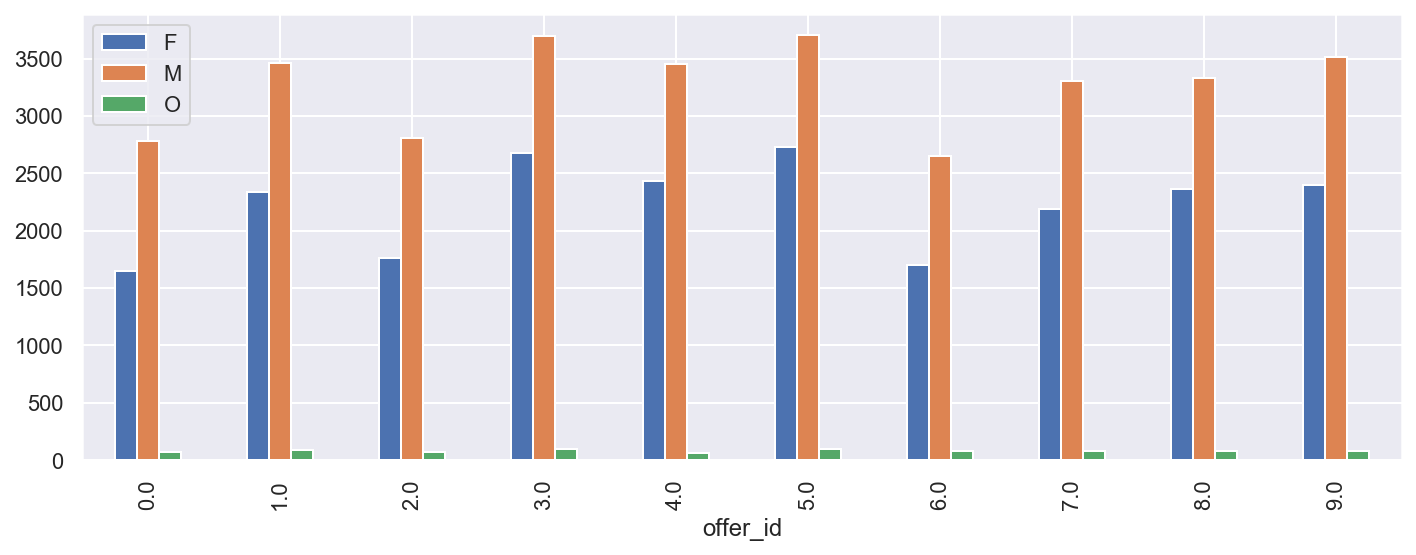

In [15]:
sns.set()
plt.figure(figsize=(10, 4))
data.groupby('offer_id')['F','M','O'].sum().plot.bar(figsize=(10, 4))
save_fig('gender_distribution')
plt.show()

Saving figure proportion_target_by_gender


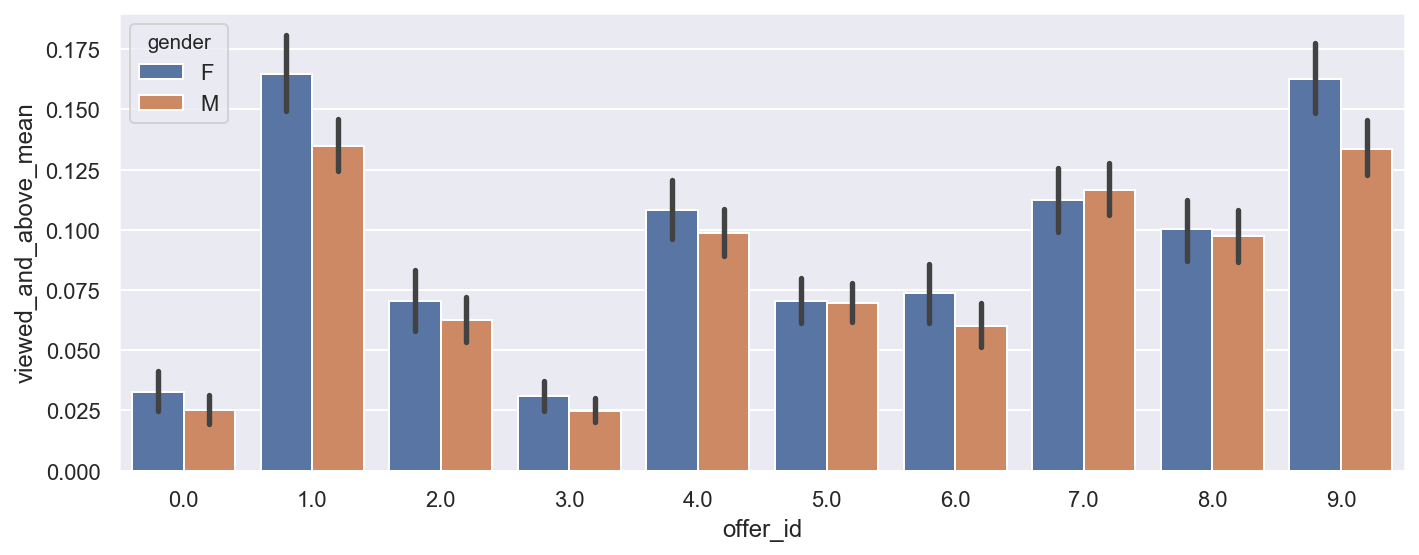

In [16]:
sns.set()
plt.figure(figsize=(10, 4))
sns.barplot(x="offer_id", y="viewed_and_above_mean", hue="gender", data=data[data['gender']!='O'])
save_fig('proportion_target_by_gender')
plt.show()

male and female customers have quite different response for offer 0, 3, 4, 5.

### The year of becoming member

Saving figure member_year


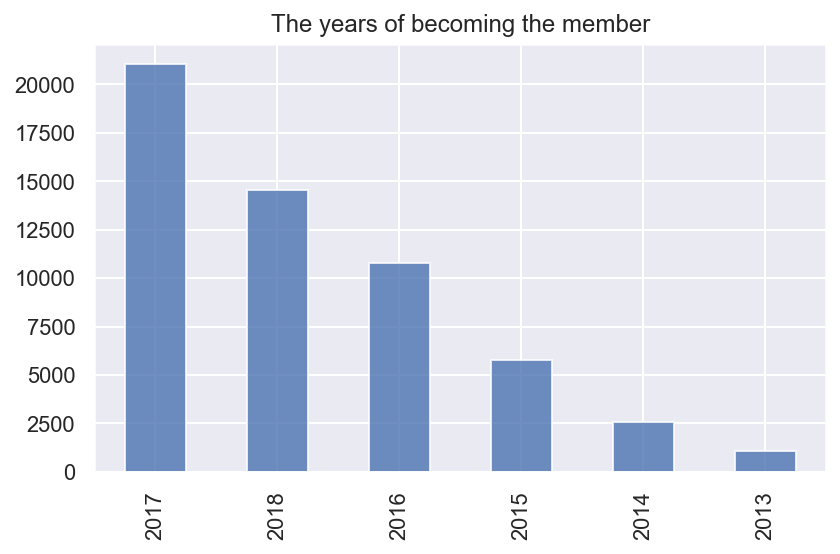

Saving figure proportion_target_by_member_year


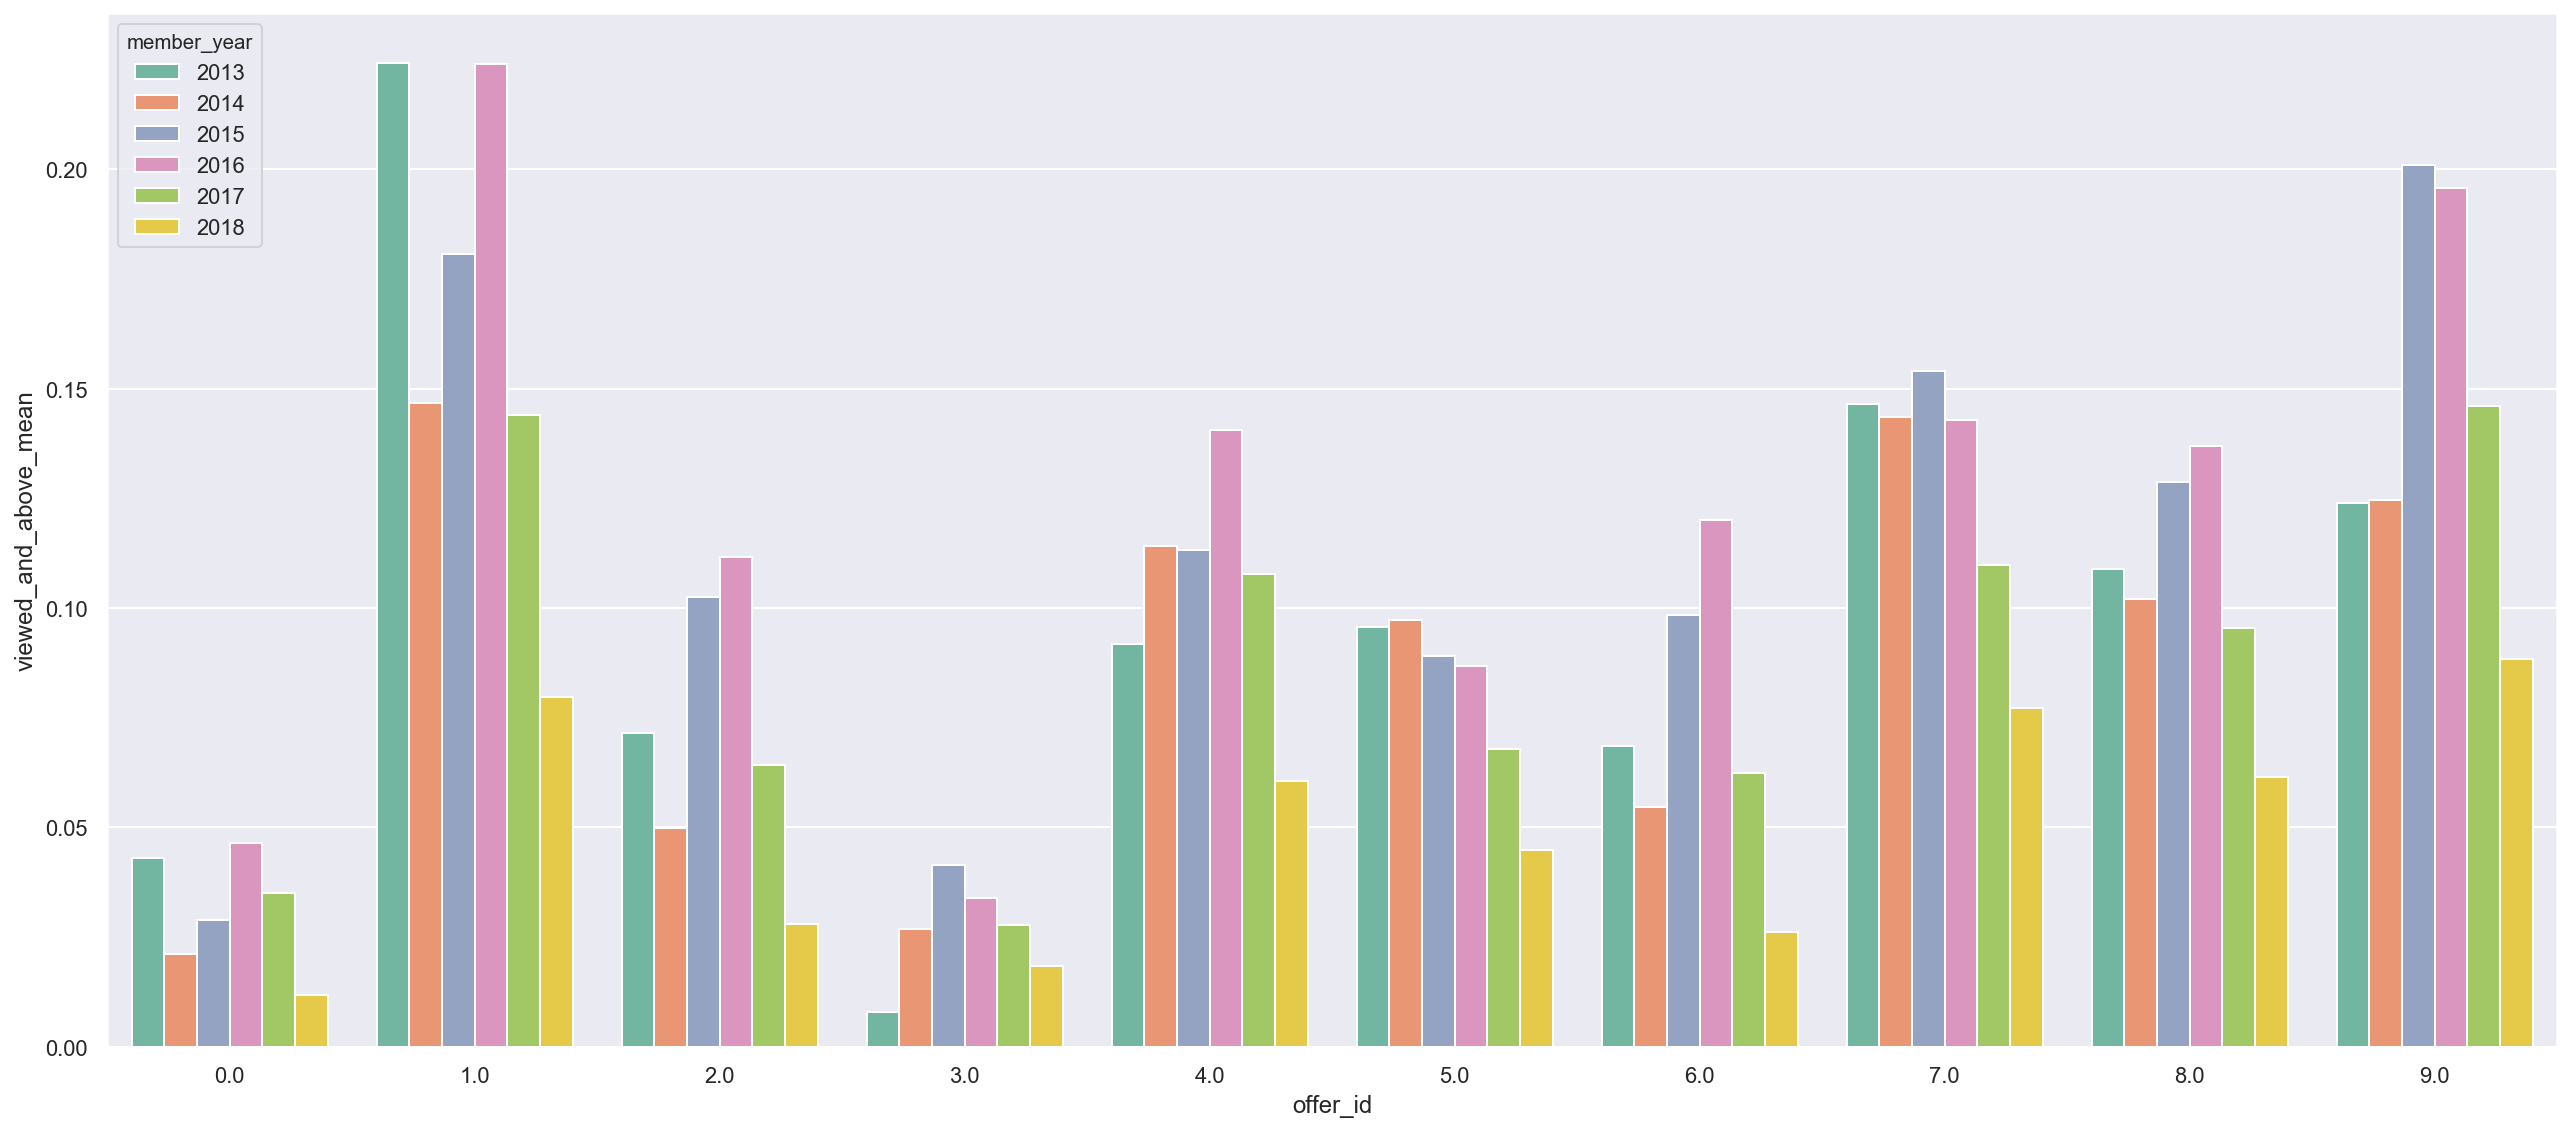

In [17]:
member_years = data['member_year'].value_counts()
member_years.plot.bar(alpha=0.8)
plt.title('The years of becoming the member')
save_fig('member_year')
plt.show()

plt.figure(figsize=(18, 8))
sns.barplot(x="offer_id", y="viewed_and_above_mean", hue="member_year", data=data, ci=None,palette="Set2")
save_fig('proportion_target_by_member_year')
plt.show()

### The month of becoming member

Saving figure member_month


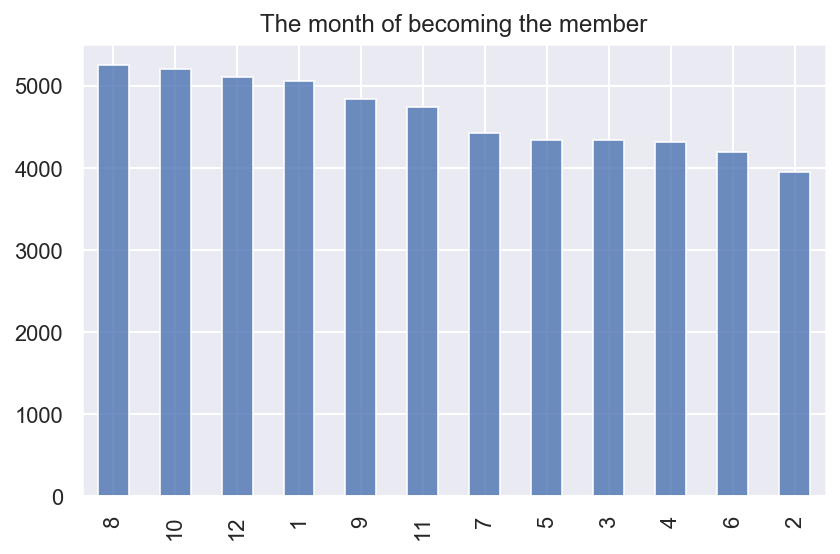

Saving figure proportion_target_by_member_month


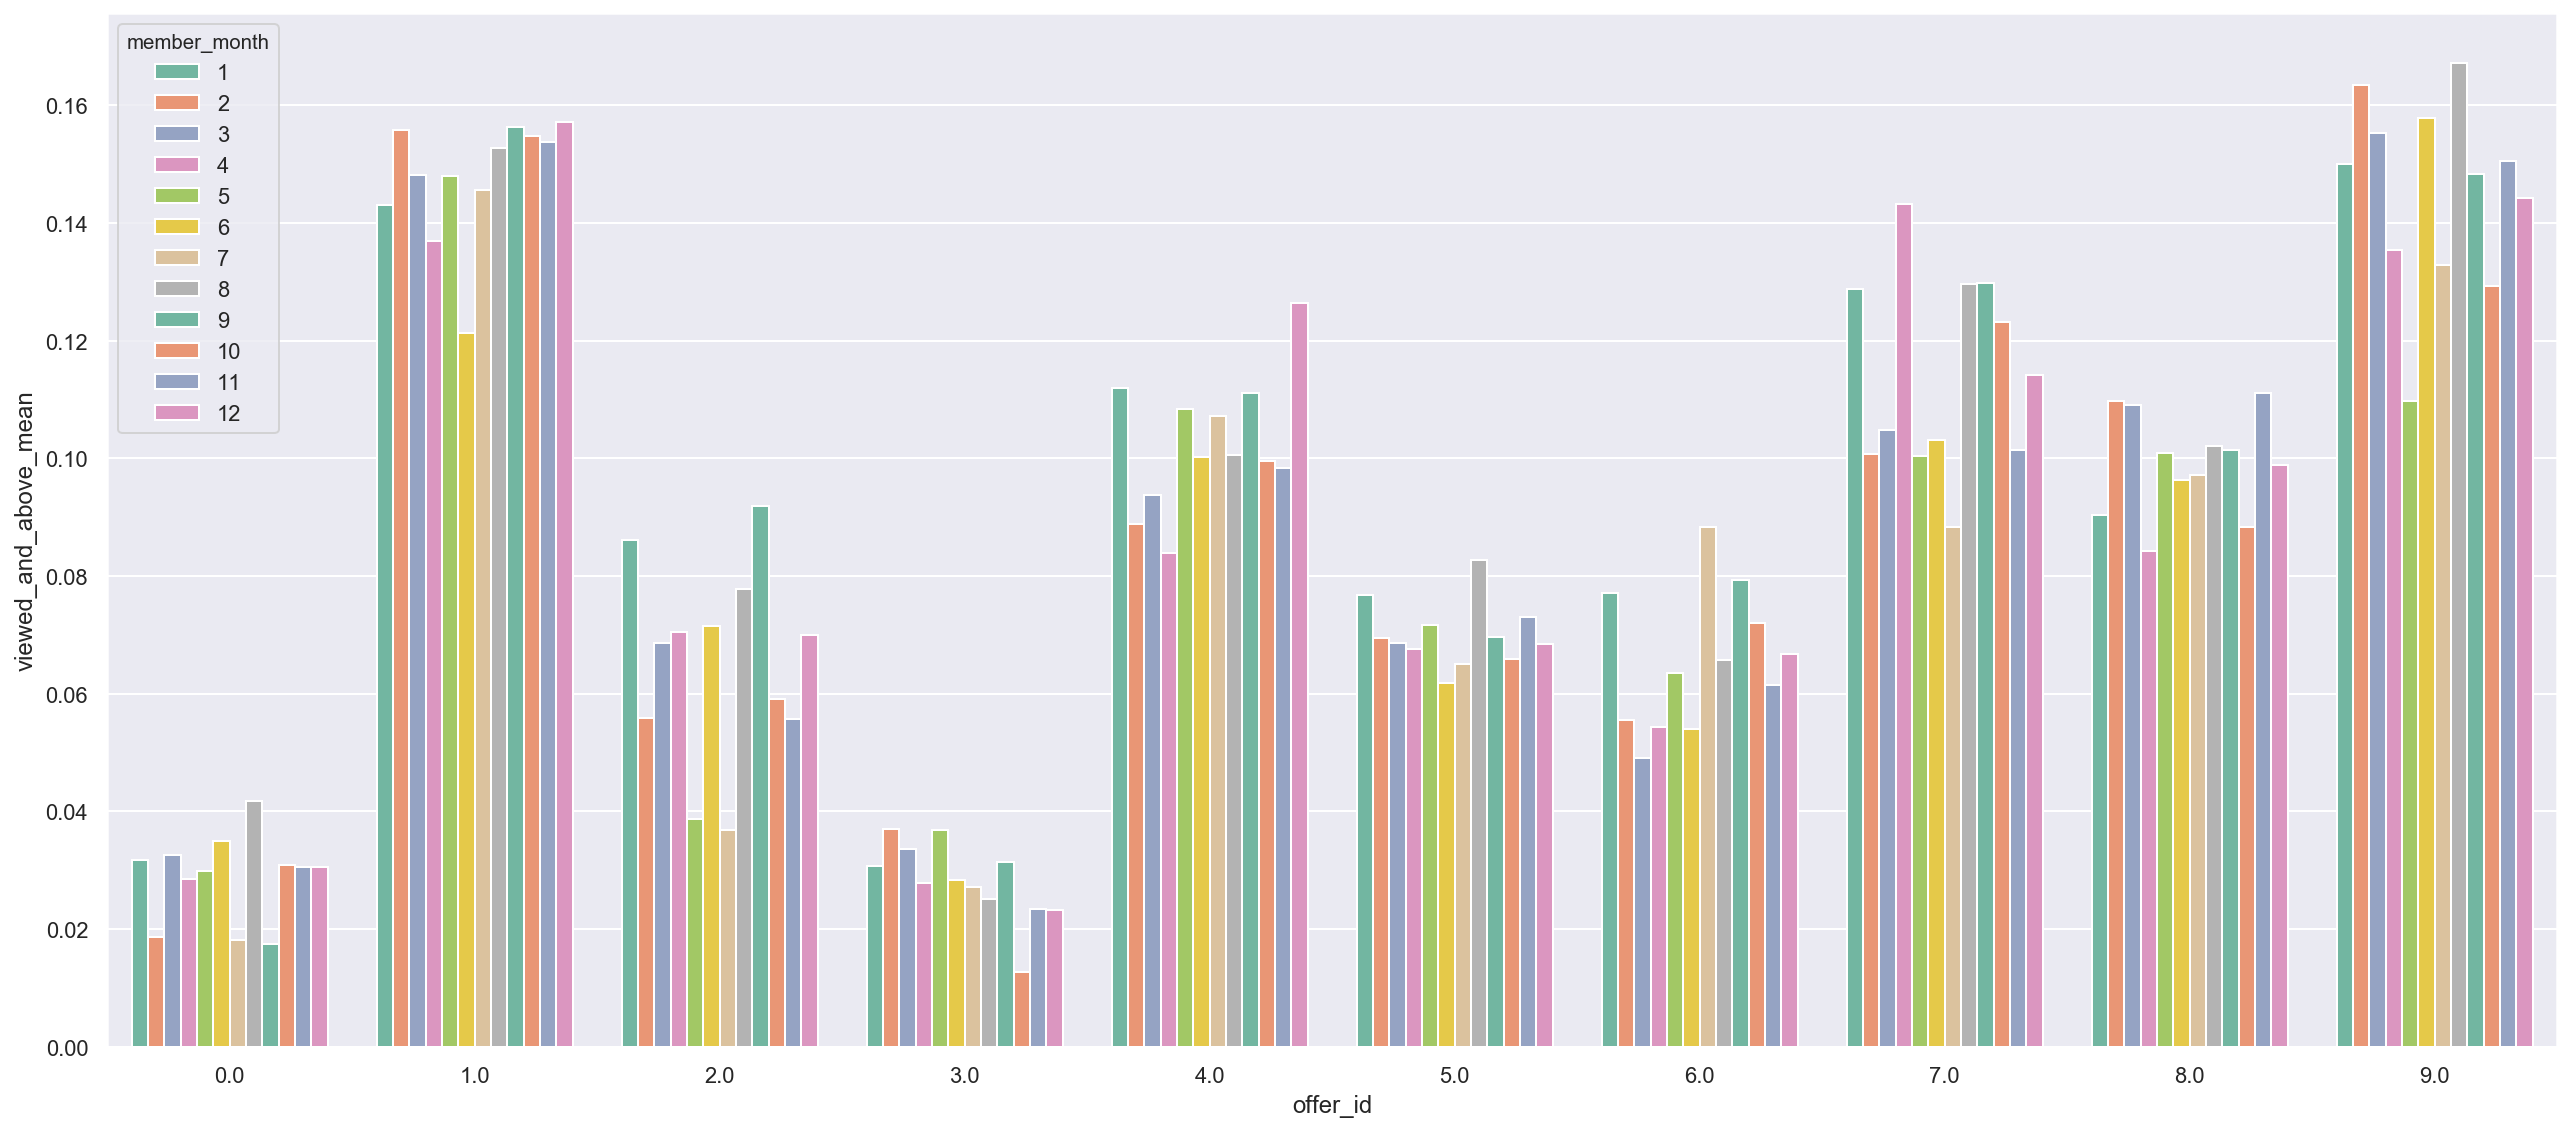

In [18]:
member_month = data['member_month'].value_counts()
member_month.plot.bar(alpha=0.8)
plt.title('The month of becoming the member')
save_fig('member_month')
plt.show()

plt.figure(figsize=(18, 8))
sns.barplot(x="offer_id", y="viewed_and_above_mean", hue="member_month", data=data, ci=None, palette="Set2")
save_fig('proportion_target_by_member_month')
plt.show()

### Age

Saving figure age
Saving figure proportion_target_by_age_by_decade


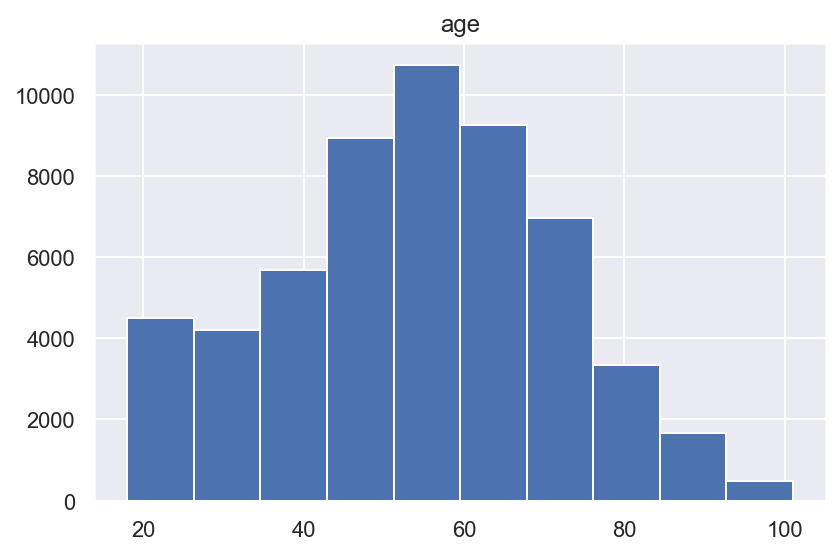

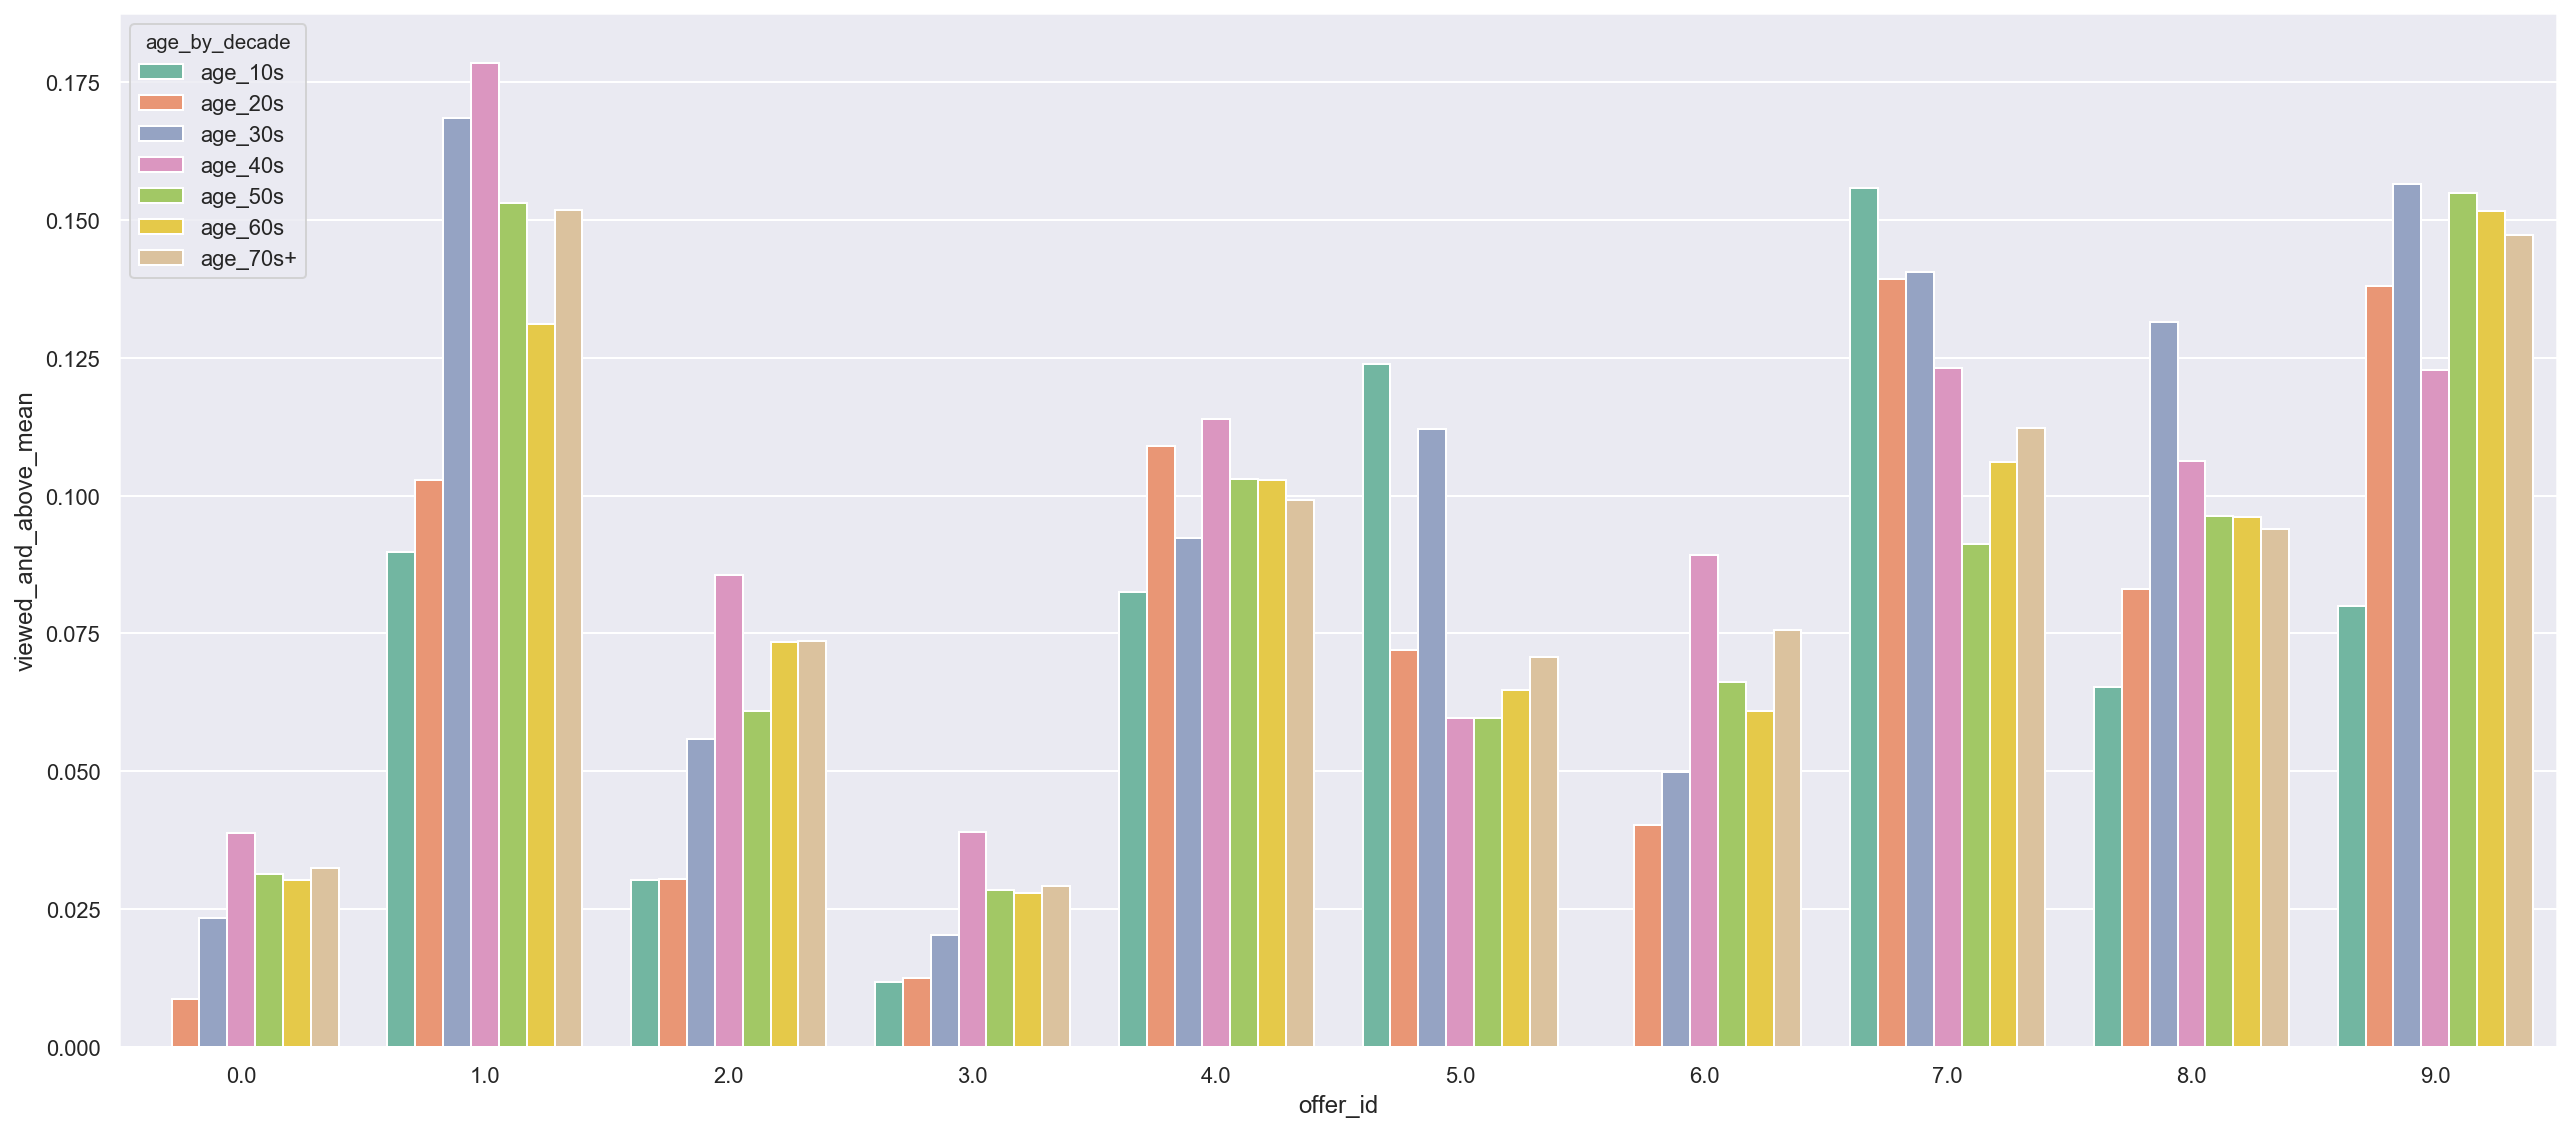

In [37]:
data['age'].hist(bins=10)
plt.title('age')
save_fig('age')
plt.figure(figsize=(18, 8))
sns.barplot(x="offer_id", y="viewed_and_above_mean", hue="age_by_decade", data=data, ci=None, palette="Set2")
save_fig('proportion_target_by_age_by_decade')
plt.show()

### income

Saving figure income
Saving figure target_proportion_by_income


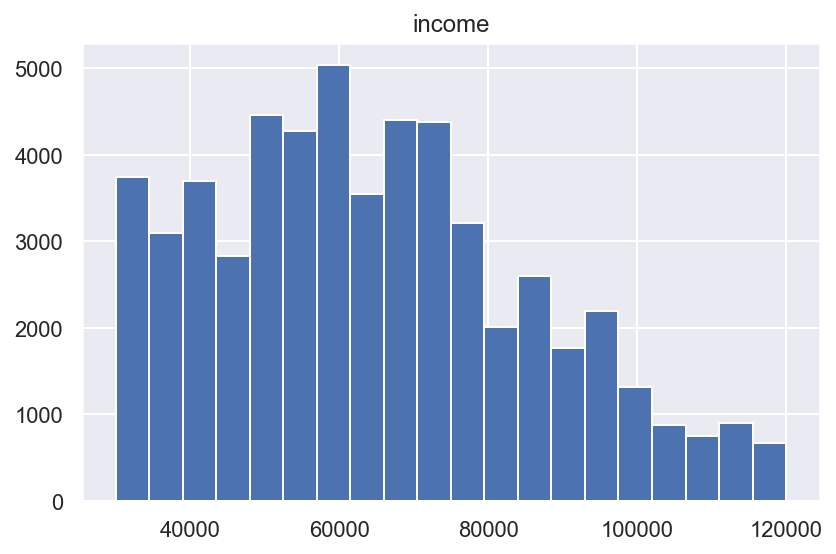

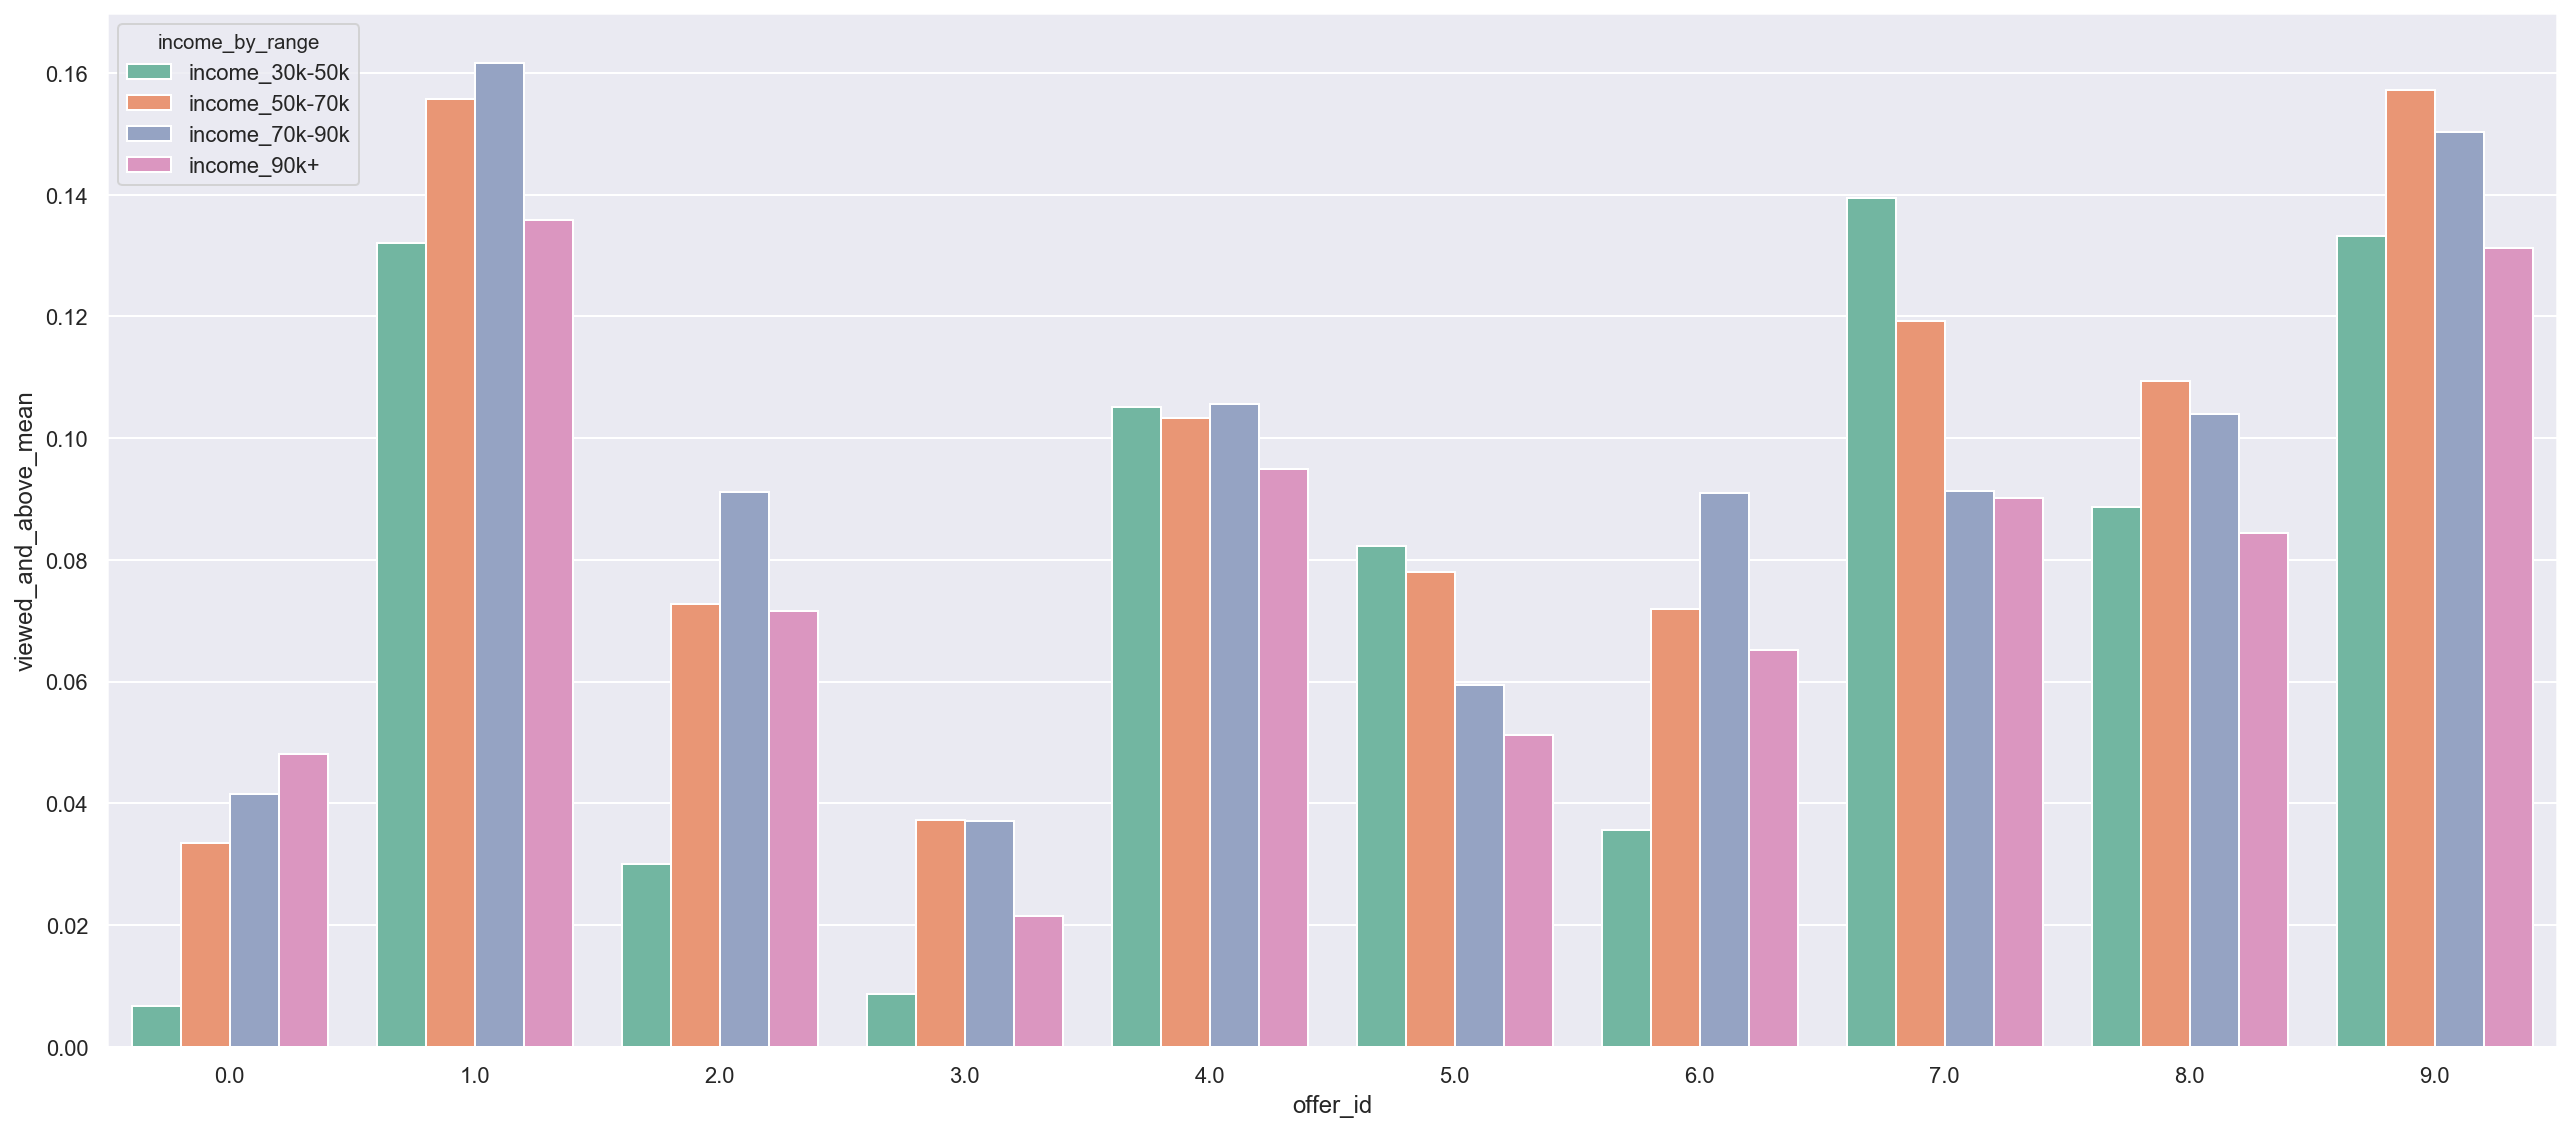

In [20]:
data['income'].hist(bins=20)
plt.title('income')
save_fig('income')
plt.figure(figsize=(18, 8))
sns.barplot(x="offer_id", y="viewed_and_above_mean", hue="income_by_range", data=data, ci=None, palette="Set2")
save_fig('target_proportion_by_income')
plt.show()

### Total spent

Saving figure total_spent
Saving figure total_spent_by_range


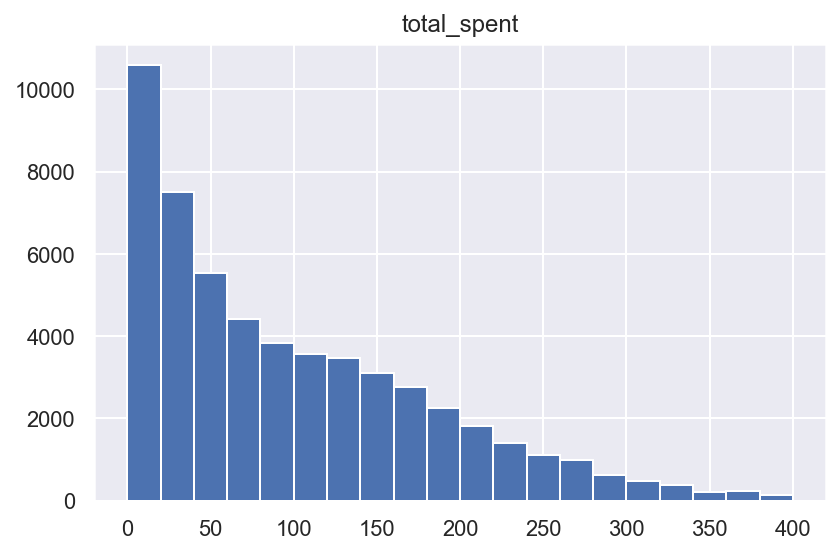

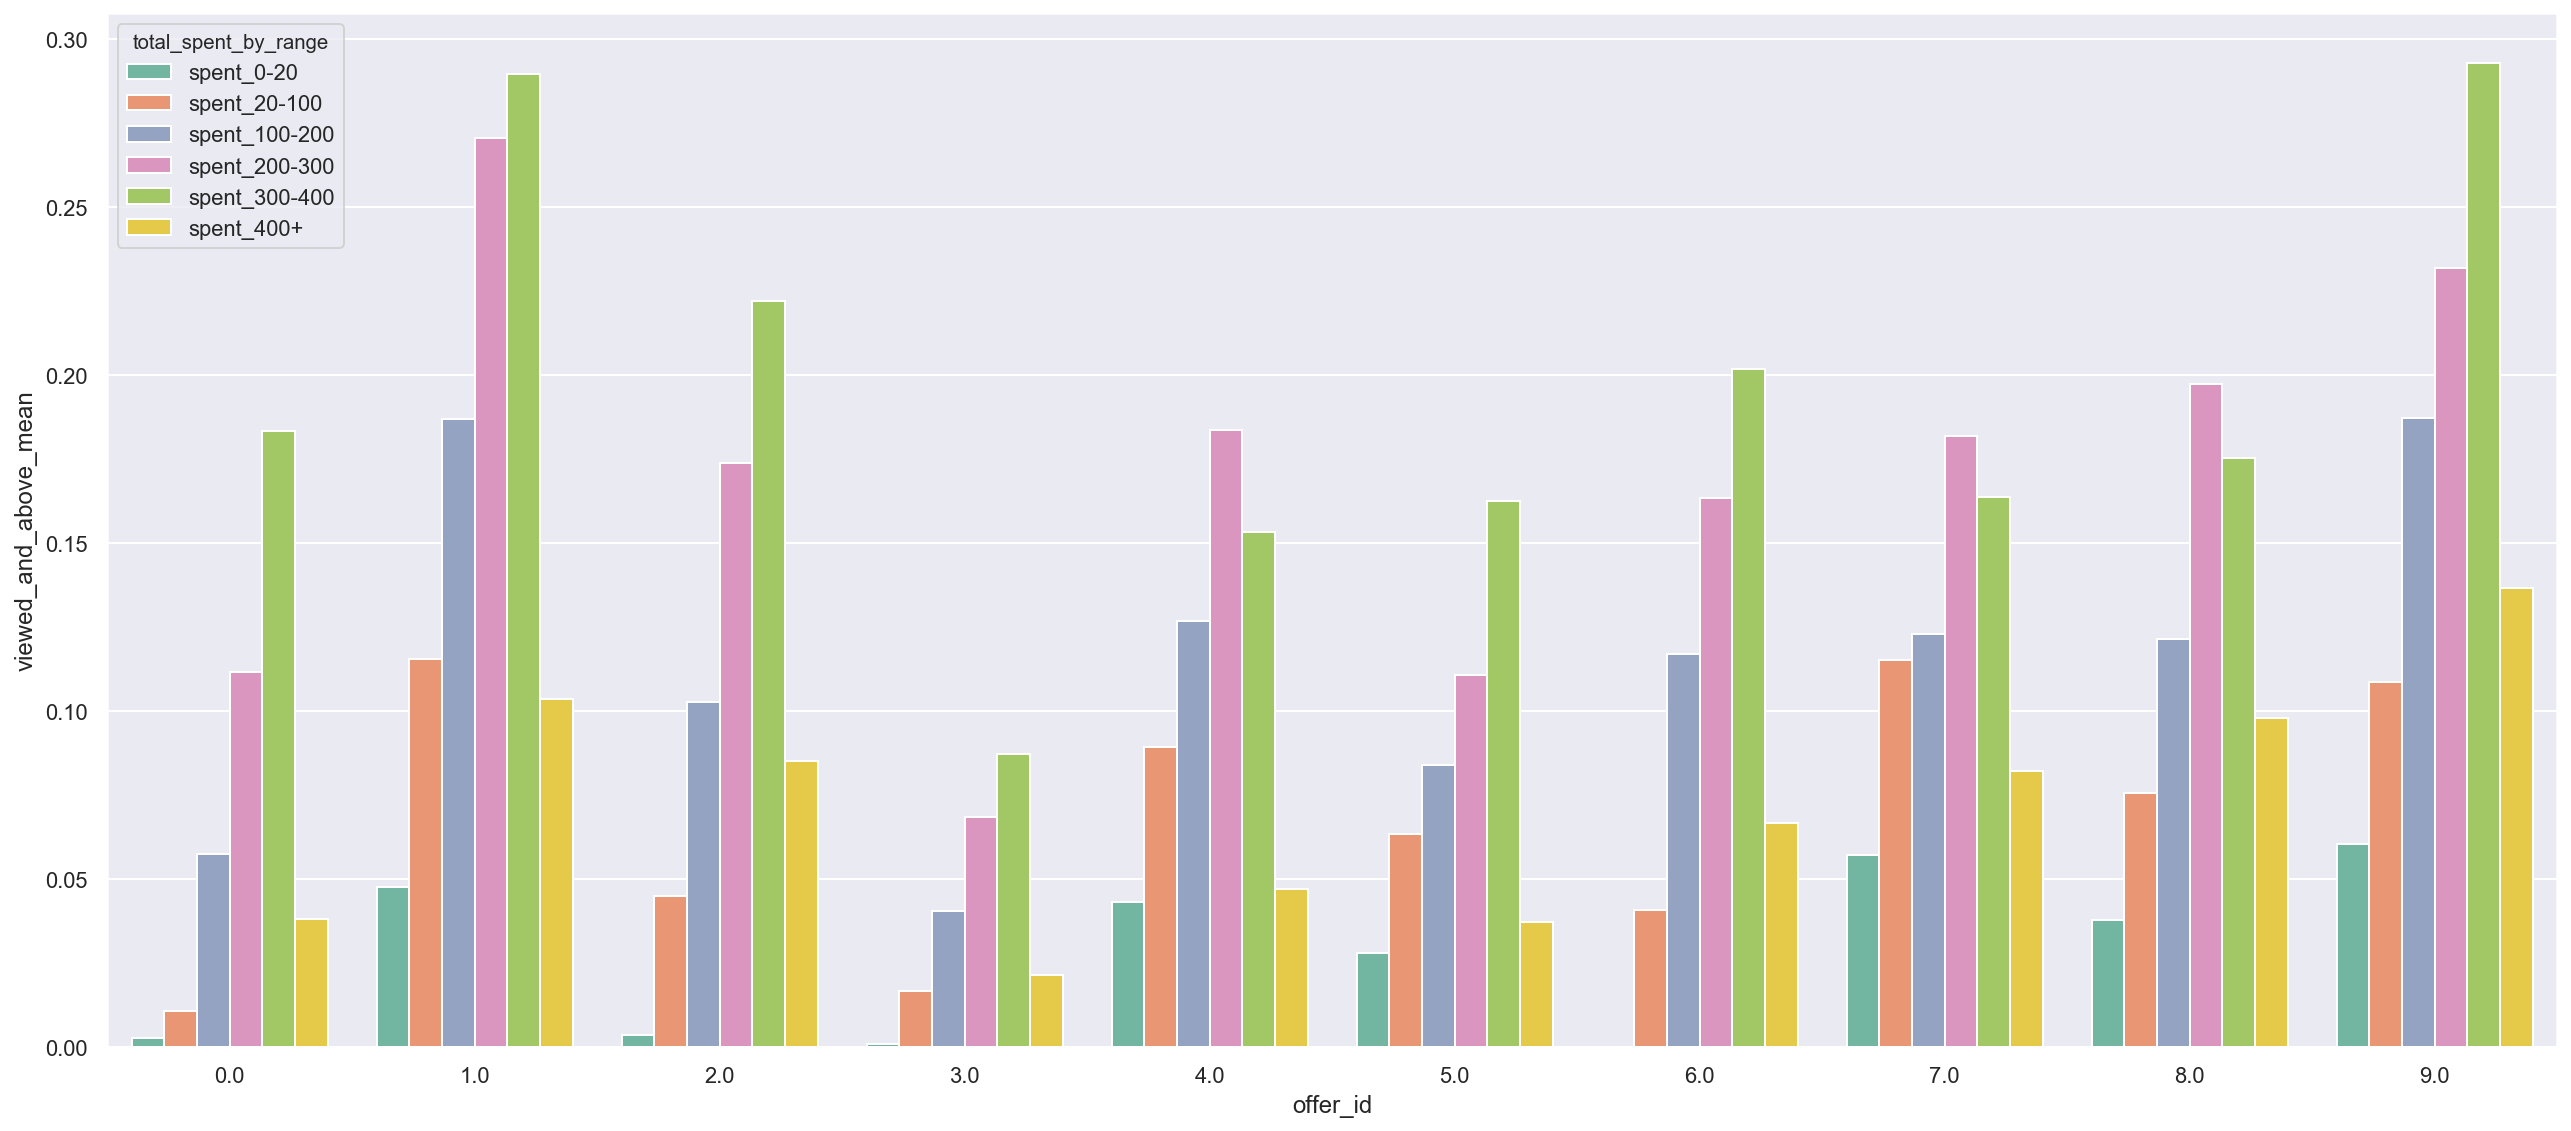

In [21]:
data['total_spent'].hist(bins=20, range=(0,400))
plt.title('total_spent')
save_fig('total_spent')
plt.figure(figsize=(18, 8))
sns.barplot(x="offer_id", y="viewed_and_above_mean", hue='total_spent_by_range', data=data, ci=None, palette="Set2")
save_fig('total_spent_by_range')
plt.show()

### numbers of transactions

Saving figure num_transactions
Saving figure target_num_transactions


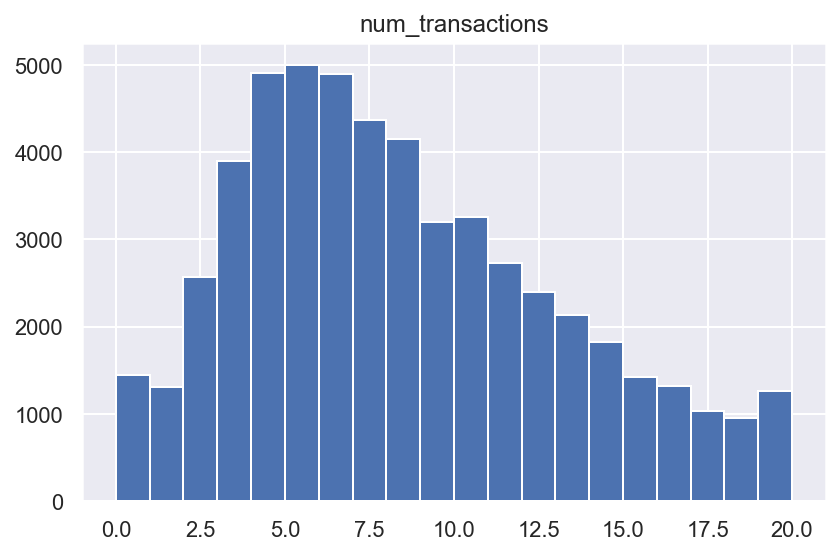

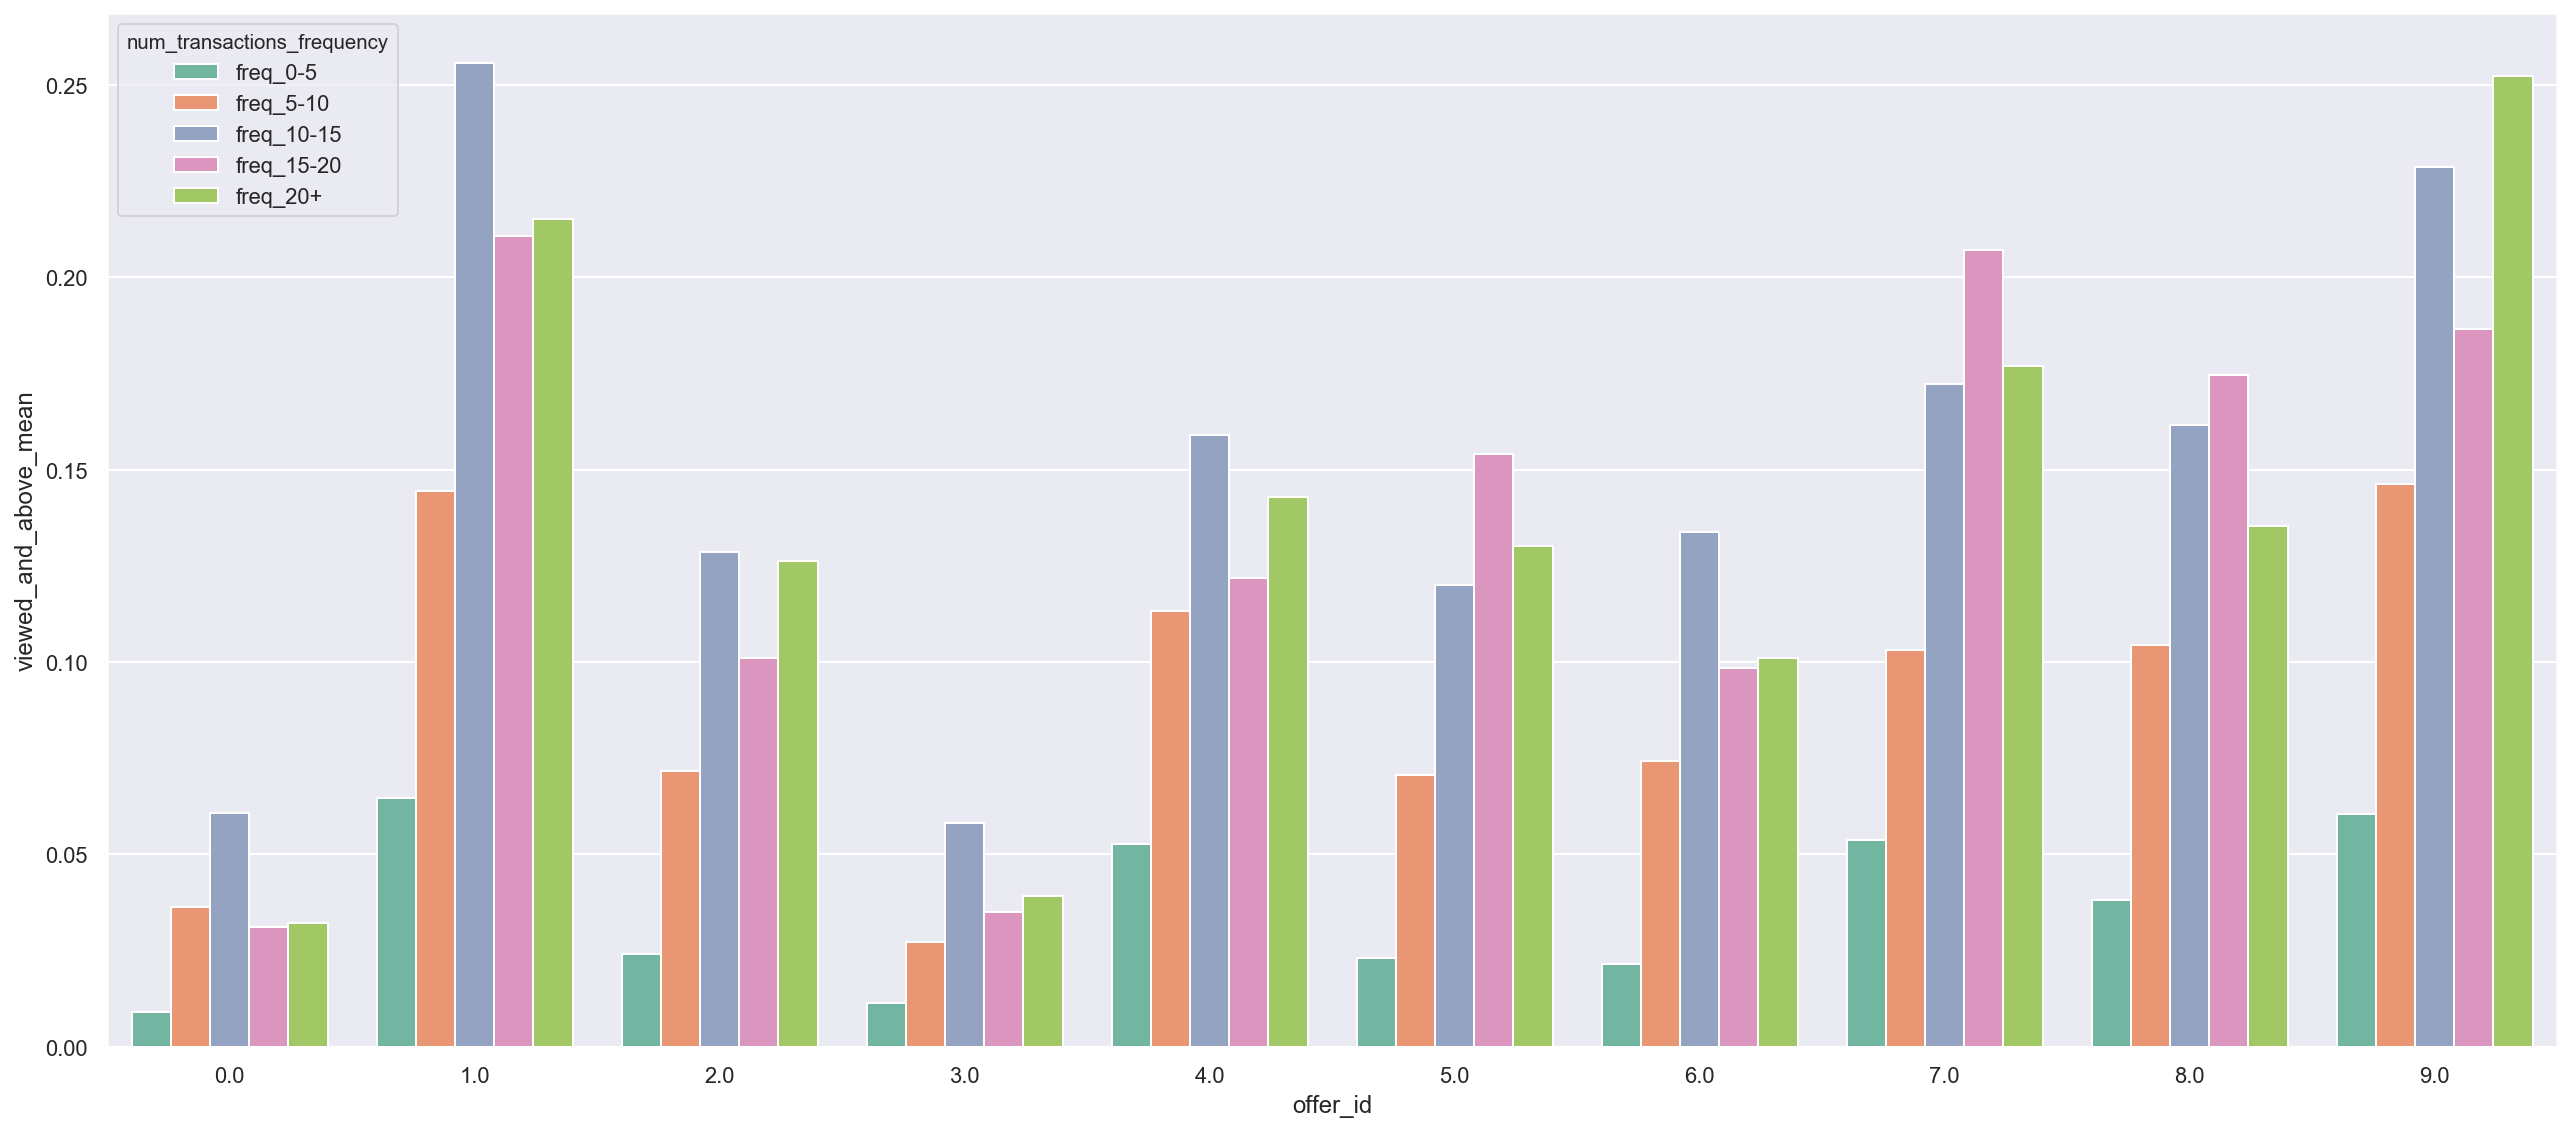

In [22]:
data['num_transactions'].hist(bins=20, range=(0,20))
plt.title('num_transactions')
save_fig('num_transactions')
plt.figure(figsize=(18, 8))
sns.barplot(x="offer_id", y="viewed_and_above_mean", hue='num_transactions_frequency', data=data, ci=None, palette="Set2")
save_fig('target_num_transactions')
plt.show()

### spent per transaction

Saving figure spent_per_transaction
Saving figure target_spent_per_transaction


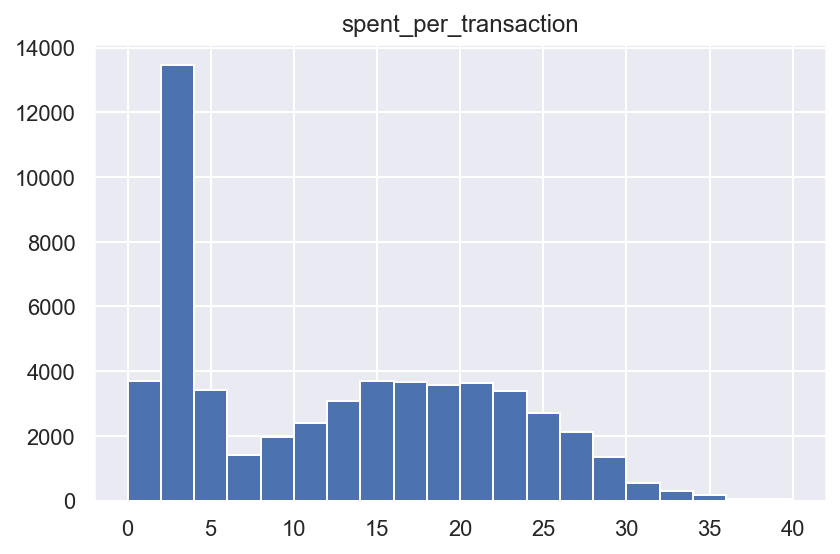

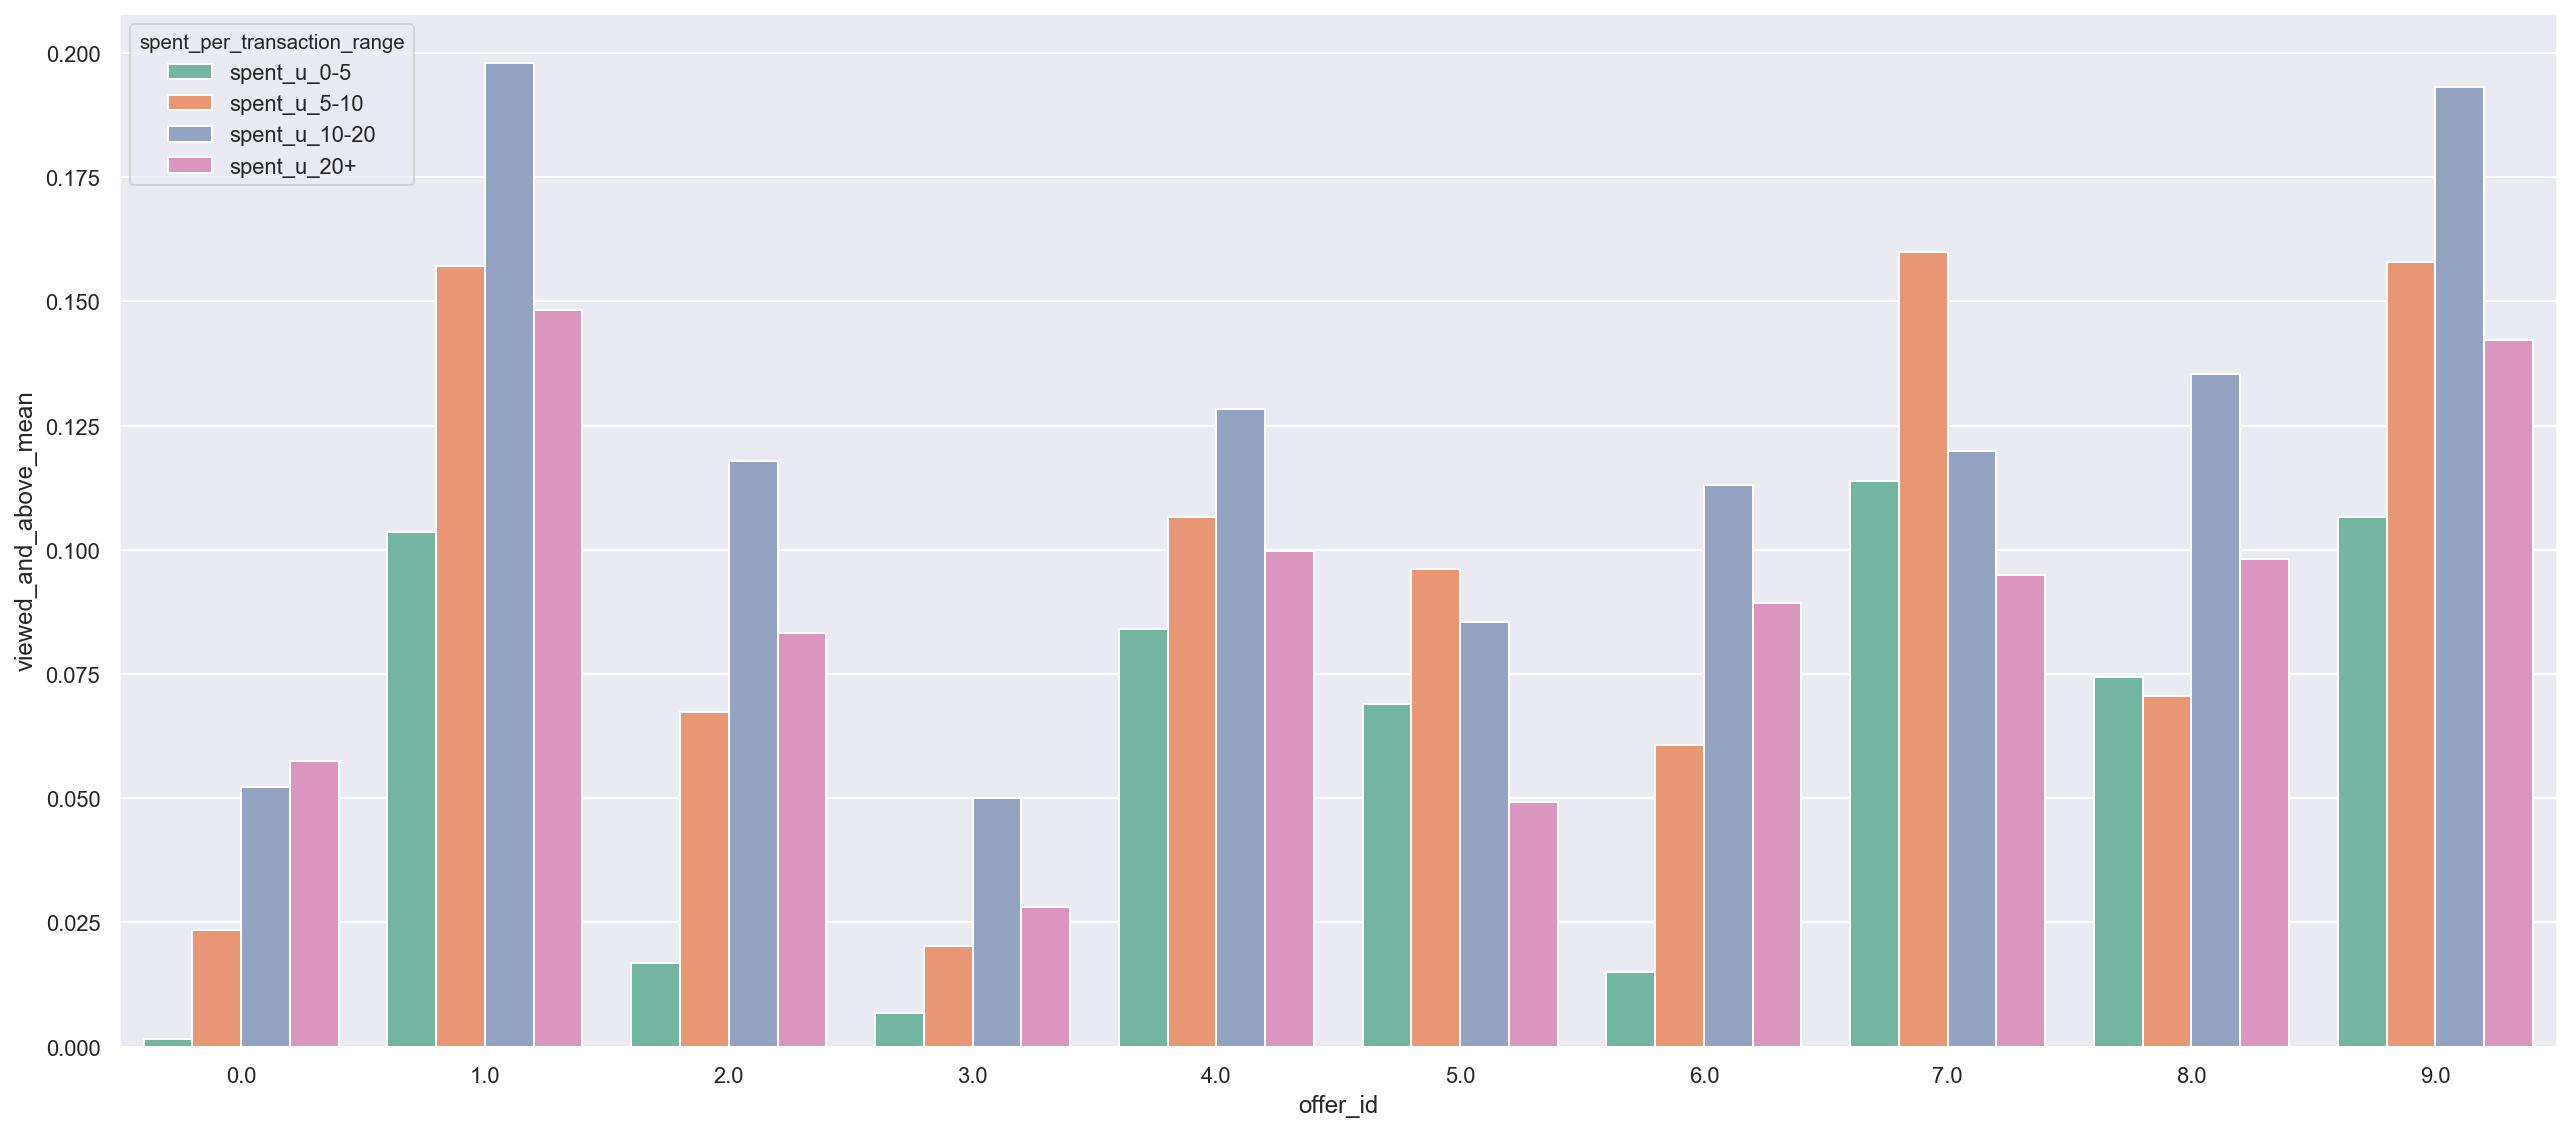

In [23]:
data['spent_per_transaction'].hist(bins=20, range=(0,40))
plt.title('spent_per_transaction')
save_fig('spent_per_transaction')
plt.figure(figsize=(18, 8))
sns.barplot(x="offer_id", y="viewed_and_above_mean", hue='spent_per_transaction_range', data=data, ci=None, palette="Set2")
save_fig('target_spent_per_transaction')
plt.show()

Prepare the dataset for modelling

In [35]:
# one hot encoding + continous numerical feature
data1 = data.drop(columns=['person_id', 'month_num','gender', 'member_year', 'member_month',
                           'member_day','profit', 'failed_offer', 'mean', 'above_mean',
                           'std', 'age_by_decade','income_by_range', 'total_spent_by_range', 
                           'num_transactions_frequency','spent_per_transaction_range', 
                           'membership_years', 'reward', 'difficulty', 'duration'])
data1.to_pickle('data1.pkl')
data1.columns

Index(['offer_id', 'viewed_and_above_mean', 'mobile', 'email', 'web', 'social',
       'age', 'income', 'F', 'M', 'O', '2013', '2014', '2015', '2016', '2017',
       '2018', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'total_spent', 'num_transactions', 'spent_per_transaction'],
      dtype='object')

In [30]:
# one hot encoding + discrete numerical feature
data2 = data.drop(columns=['person_id', 'month_num','gender',  'member_year', 'profit', 'failed_offer', 'mean',
                           'std', 'gender', 'age', 'income', 'total_spent', 'num_transactions', 'above_mean',
                           'spent_per_transaction','member_year', 'member_month', 'member_day', 
                           'age_by_decade','income_by_range', 'total_spent_by_range', 'reward', 'difficulty', 
                           'duration','num_transactions_frequency','spent_per_transaction_range', 'membership_years'])
one_hot_labels = ['age_by_decade','income_by_range', 'total_spent_by_range', 'num_transactions_frequency',
                   'spent_per_transaction_range']
for label in one_hot_labels:
    data2 = pd.concat([data2, pd.get_dummies(data[label])], axis=1)
data2.to_pickle('data2.pkl')
data2.columns

Index(['offer_id', 'viewed_and_above_mean', 'mobile', 'email', 'web', 'social',
       'F', 'M', 'O', '2013', '2014', '2015', '2016', '2017', '2018',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'age_10s', 'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s',
       'age_70s+', 'income_30k-50k', 'income_50k-70k', 'income_70k-90k',
       'income_90k+', 'spent_0-20', 'spent_20-100', 'spent_100-200',
       'spent_200-300', 'spent_300-400', 'spent_400+', 'freq_0-5', 'freq_5-10',
       'freq_10-15', 'freq_15-20', 'freq_20+', 'spent_u_0-5', 'spent_u_5-10',
       'spent_u_10-20', 'spent_u_20+'],
      dtype='object')

In [26]:
# # label encode + continous numerical data
# data3 = data[['person_id', 'month_num', 'offer_id', 'profit', 'mean', 'std',
#              'above_mean', 'viewed_and_above_mean', 'mobile', 'email', 'web', 'social',
#              'F','M','O', 'member_year', 'member_month', 'age','income',
#              'total_spent','num_transactions','spent_per_transaction']]
# data3.to_pickle('data3.pkl')
# data3.columns

In [27]:
# # label encoder + discrete_features
# data4 = data[['person_id', 'month_num', 'offer_id', 'profit', 'mean', 'std',
#              'above_mean', 'viewed_and_above_mean', 'mobile', 'email', 'web', 'social',
#              'F','M','O', 'member_year', 'member_month']]

# ordinal_labels = ['age_by_decade','income_by_range', 'total_spent_by_range', 'num_transactions_frequency',
#                    'spent_per_transaction_range']
# encoder = OrdinalEncoder()
# data4 = pd.concat([data4, pd.DataFrame(encoder.fit_transform(data[ordinal_labels]), 
#                           columns=ordinal_labels, index=data[ordinal_labels].index)], axis=1)
# data4.to_pickle('data4.pkl')
# data4.columns